In [2]:
import tensorflow.keras as keras
from tensorflow.keras import backend as K
import numpy as np
from IPython.display import display
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
%matplotlib inline

In [3]:
image_dim = (128, 128)
image_count = 100

X = np.array([
    [
        [[0, 0, 0] for col in range(image_dim[1])]
        for row in range(image_dim[0])
    ] for _ in range(image_count)
])
Y = np.array([0 for _ in range(image_count)])

display(X.shape)
display(Y.shape)

(100, 128, 128, 3)

(100,)

Model: "NFT_Valuator"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input_Layer (InputLayer)        [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
First_Convolution (Conv2D)      (None, 121, 121, 128 24704       Input_Layer[0][0]                
__________________________________________________________________________________________________
Second_Convolution (Conv2D)     (None, 116, 116, 256 1179904     First_Convolution[0][0]          
__________________________________________________________________________________________________
Third_Convolution (Conv2D)      (None, 114, 114, 64) 147520      Second_Convolution[0][0]         
_______________________________________________________________________________________

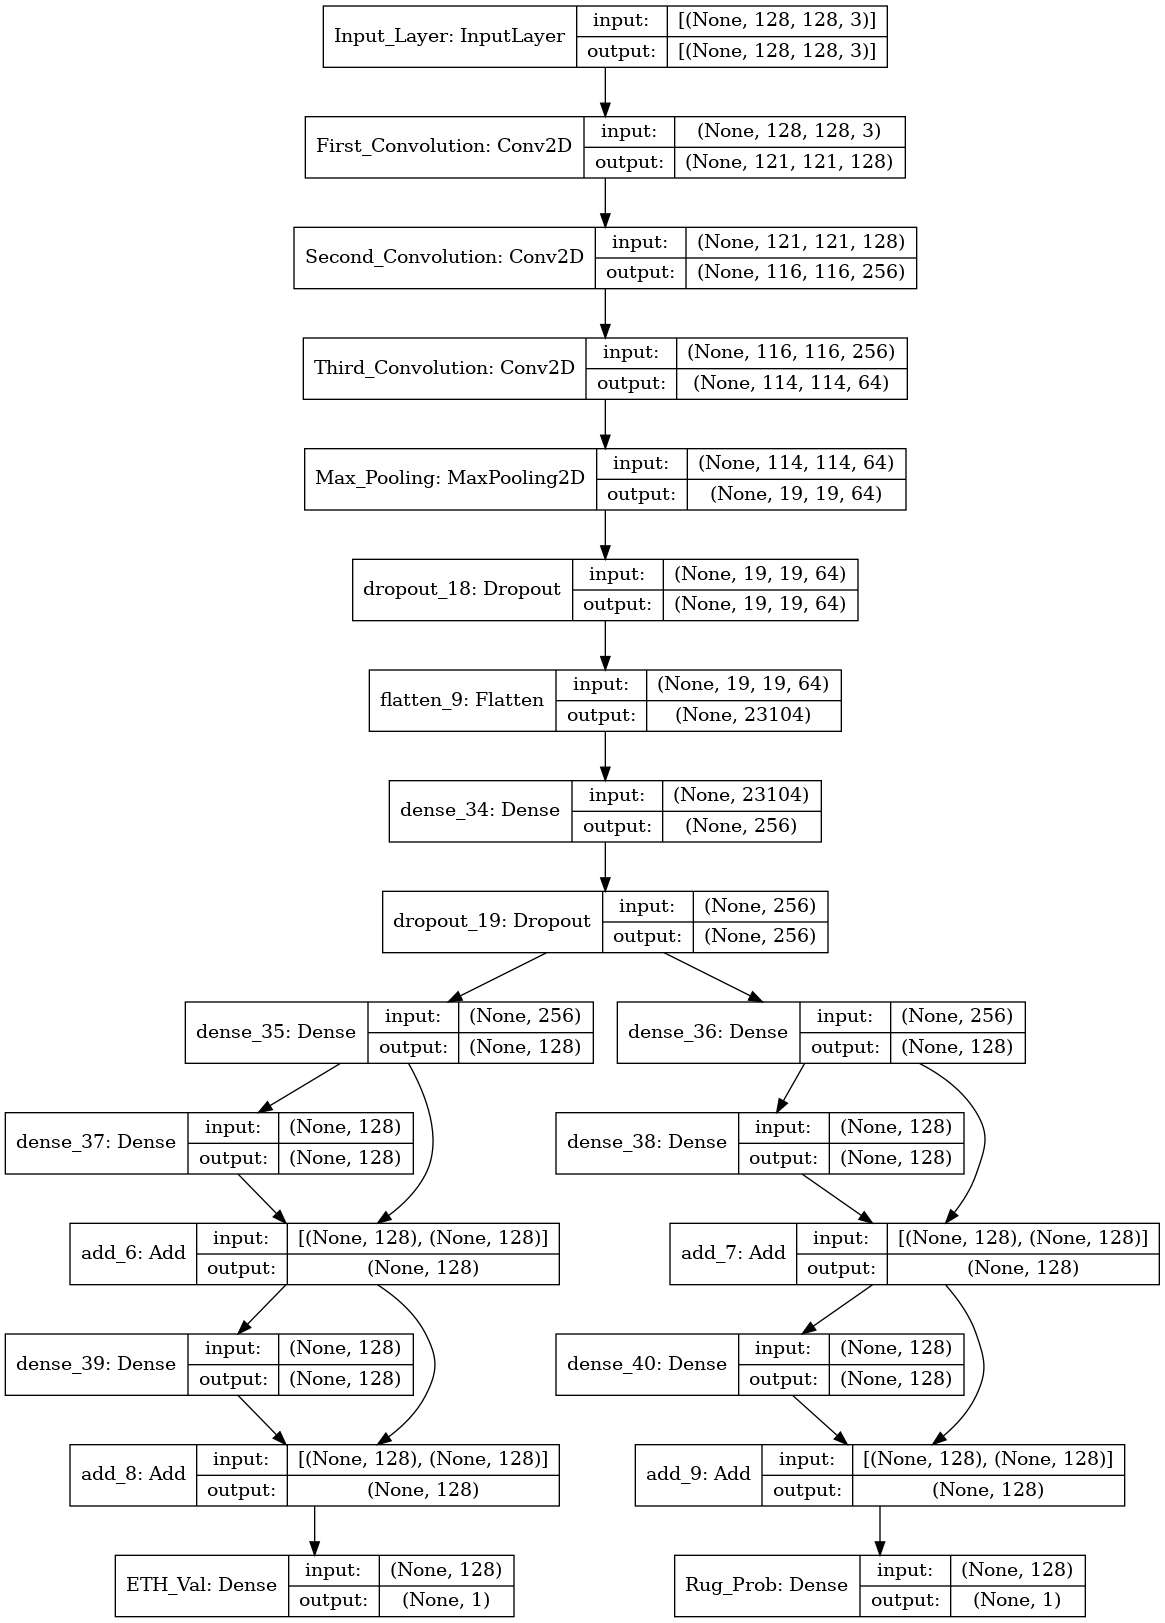

In [13]:
x = keras.layers.Input(X.shape[1:], name="Input_Layer")
y = x
y = keras.layers.Conv2D(128, kernel_size=(8,8), activation='relu', name="First_Convolution")(y)
y = keras.layers.Conv2D(256, kernel_size=(6,6), activation='relu', name="Second_Convolution")(y)
y = keras.layers.Conv2D(64, kernel_size=(3,3), activation='relu', name="Third_Convolution")(y)
y = keras.layers.MaxPooling2D(pool_size=(6,6), name="Max_Pooling")(y)
y = keras.layers.Dropout(0.05)(y)
y = keras.layers.Flatten()(y)
y = keras.layers.Dense(256, activation='relu')(y)
y = keras.layers.Dropout(0.125)(y)
z = keras.layers.Dense(128, activation='relu')(y)
y = keras.layers.Dense(128, activation='relu')(y)

stack = 2
for _ in range(stack):
    a = keras.layers.Dense(128, activation='relu')(z)
    b = keras.layers.Dense(128, activation='relu')(y)
    c = keras.layers.Add()([a, z])
    d = keras.layers.Add()([b, y])
    z, y = c, d
# y = keras.layers.LayerNormalization()(y)
# Output Logits (10)
a = keras.layers.Dense(1, activation='relu', name="ETH_Val")(z) # Ethereum value of the NFT
y = keras.layers.Dense(1, activation='sigmoid', name="Rug_Prob")(y) # Whether or not the NFT will "rug" (scam its buyers)
z = a
model = keras.Model(x,[z, y])
generator = keras.preprocessing.image.ImageDataGenerator(
    width_shift_range=0.05,
    height_shift_range=0.05,
    rotation_range=5,
    zoom_range=0.1,
    horizontal_flip=True
)
model.compile(
    loss=[keras.losses.MeanSquaredError(), keras.losses.BinaryCrossentropy()],
    optimizer=keras.optimizers.Adam(),
    metrics=[keras.metrics.MeanAbsolutePercentageError(), keras.metrics.BinaryAccuracy()]
)
model._name = "NFT_Valuator"

model.summary()
keras.utils.plot_model(model, show_shapes=True, expand_nested=True)